## Preparing the data

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, preprocessing
import tensorflow as tf

from tensorflow.keras import regularizers

In [2]:
''''Get the tabular data from github and the images from google.drive or drive of computer'''

# data from the computer
#path = "C:\\Users\\brian\\Desktop\\minor\\AI project\\model"
# os.chdir(path)
# train_data = pd.read_csv('petfinder-pawpularity-score/train.csv')
# train_data['Pawpularity'] = train_data['Pawpularity']
# display(train_data.head(5))
# csv file as a dataframe

# data from github
url = 'https://raw.githubusercontent.com/Veer56/Pawl_patrol/main/Code/data/train.csv'
train_data = pd.read_csv(url)
train_data.isnull().values.any()
display(train_data.head(5))
display(train_data.describe())

# unzip the images from the zip that is in google drive
from google.colab import drive
drive.mount('/content/gdrive')
!unzip gdrive/My\ Drive/Data/petfinder-pawpularity-score.zip

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
count,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000
mean,0.027643,0.772599,0.903955,0.861582,0.009988,0.067797,0.129338,0.049637,0.166263,0.172014,0.061239,0.070420,38.039044
std,0.163957,0.419175,0.294668,0.345356,0.099444,0.251409,0.335591,0.217204,0.372335,0.377411,0.239780,0.255866,20.591990
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000
50%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000
75%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Archive:  gdrive/My Drive/Data/petfinder-pawpularity-score.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
''' Load the images from the zipfile, resize them and return them as a array, 
  also get the names of the images from the file to find the correspondending data
  in the dataframe and get the pawpularity as label for every image'''

def load_images_from_folder(folder, data = [], size=64):
    images = []
    labels = []
    names = []
    for filename in os.listdir(folder):
        name = filename.strip('.jpg')
        names.append(name)
        labels.append(data.loc[data['Id']== name]['Pawpularity'].item())
        img = cv2.resize(cv2.imread(os.path.join(folder,filename)), (size, size))
        if img is not None:
            images.append(img)
    return np.array(images), labels, names

image, image_labels, image_names = load_images_from_folder('train', data = train_data)

print(f'Training labels loaded: {image.shape}')

Training labels loaded: (9912, 64, 64, 3)


In [4]:
'''split the data in train and test parts of 80% for train and 20% test with random at 11'''

image_train, image_test, label_train, label_test, name_train, name_test = train_test_split(image, image_labels, image_names, test_size=0.2, random_state=11)



In [5]:
''' Test if the label and name are the same'''

print(label_train[1])
print(name_train[1])

26
cb819cac890932b06e56c831e3161727


## Making the model

In [8]:
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, preprocessing
import tensorflow as tf

In [12]:

def train_and_evaluate(model, train_x, train_y, val_x, val_y, preprocess={}, epochs=20, augment={}):
    ''' Make the model to train and evaluate the data'''

    model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['RootMeanSquaredError'])

    train_gen = preprocessing.image.ImageDataGenerator(preprocess, augment)
    train_gen.fit(train_x) 

    val_gen = preprocessing.image.ImageDataGenerator(**preprocess)
    val_gen.fit(train_x)

    history = model.fit(train_gen.flow(train_x, train_y), epochs=epochs, 
                        validation_data=val_gen.flow(val_x, val_y))

    fig, axs = plt.subplots(1,2,figsize=(20,5)) 

    for i, metric in enumerate(['loss', 'root_mean_squared_error']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_'+metric])
        axs[i].legend(['training', 'validation'], loc='best')

        axs[i].set_title('Model '+metric)
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('epoch')

    plt.show()

    print(f"Validation Accuracy: {model.evaluate(val_gen.flow(val_x, val_y))[1]}")

Epoch 1/20
248/248 [==============================] - 5s 17ms/step - loss: 1148.8419 - root_mean_squared_error: 30.5104 - val_loss: 778.5564 - val_root_mean_squared_error: 26.0568
Epoch 2/20
248/248 [==============================] - 4s 16ms/step - loss: 1060.0341 - root_mean_squared_error: 29.6002 - val_loss: 1177.6527 - val_root_mean_squared_error: 33.3685
Epoch 3/20
248/248 [==============================] - 4s 16ms/step - loss: 995.6619 - root_mean_squared_error: 28.9276 - val_loss: 1180.3168 - val_root_mean_squared_error: 33.4633
Epoch 4/20
248/248 [==============================] - 4s 16ms/step - loss: 948.0131 - root_mean_squared_error: 28.3796 - val_loss: 1078.1285 - val_root_mean_squared_error: 31.0212
Epoch 5/20
248/248 [==============================] - 4s 16ms/step - loss: 916.4918 - root_mean_squared_error: 28.1094 - val_loss: 863.1688 - val_root_mean_squared_error: 28.4147
Epoch 6/20
248/248 [==============================] - 4s 16ms/step - loss: 897.4900 - root_mean_squa

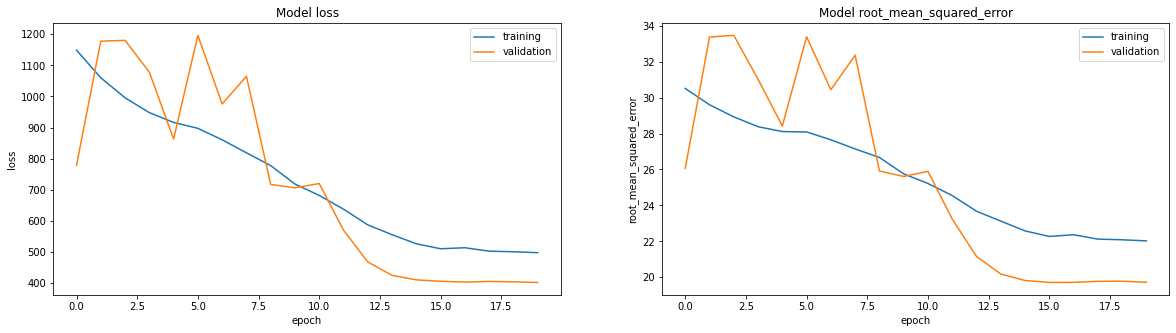

62/62 [==============================] - 0s 7ms/step - loss: 402.0788 - root_mean_squared_error: 19.7214
Validation Accuracy: 19.721405029296875


In [22]:
''' First model with 3 hidden layers, dropout, batchnormalization, activity regularizer,
  featurewise center and featurewise std normalization'''

  
# activity_regularizer=regularizers.l2(1e-3)
# kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),

model=tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(64,64,3),padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))
#model.add(layers.BatchNormalization())

model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(layers.BatchNormalization())

model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(layers.BatchNormalization())

model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Conv2D(512,(3,3),activation='relu',padding='same',activity_regularizer=regularizers.l2(1e-4)))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(layers.BatchNormalization())

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.Dense(64,activation='relu',activity_regularizer=regularizers.l2(1e-1)))
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.Dense(1,activation=None))

preprocess = {'featurewise_center': True, 'featurewise_std_normalization': True}

# train the model and evaluate it with the test_data
train_and_evaluate(model, image_train, label_train, image_test, label_test, preprocess=preprocess, epochs=20)

# Tabular Data
Four models for training with all the features of the tabular data of the images. Last model is to compare the difference in using the tabular data or not.

In [4]:
''' Divide the data in train and test with the tabular features inculded (X)'''

X = np.array(train_data[['Subject Focus', 'Eyes', 'Face', 'Near', "Action", 'Accessory','Group', 'Collage','Human', 'Occlusion', 'Info', 'Blur']])

image_train, image_test, label_train, label_test, X_train, X_test = train_test_split(image, image_labels, X, test_size=0.2, random_state=11)

In [6]:
''' Second methode of train and evaluate that can handle the combined data of images
   and tabular'''

def train_and_evaluate_2(model, train_x, train_y, val_x, val_y, X_train, X_test, preprocess={}, epochs=20, augment={}):
    ''' Make the model to train and evaluate the data'''

    # compile the model using adam as optimizer with mean squared error as loss function
    model.compile(optimizer='adam',
              loss='MSE',
              metrics=['RootMeanSquaredError'])

    train_gen = preprocessing.image.ImageDataGenerator(preprocess, augment)
    train_gen.fit(train_x) 

    val_gen = preprocessing.image.ImageDataGenerator(**preprocess)
    val_gen.fit(val_x)

    # estimate the model using the compile 
    history = model.fit(train_gen.flow((train_x, X_train), train_y), epochs=epochs, 
                        validation_data=val_gen.flow((val_x, X_test), val_y))

    fig, axs = plt.subplots(1,2,figsize=(20,5)) 

    # plot the learning curves
    for i, metric in enumerate(['loss', 'root_mean_squared_error']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_'+metric])
        axs[i].legend(['training', 'validation'], loc='best')

        axs[i].set_title('Model '+metric)
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('epoch')

    plt.show()

Epoch 1/20
248/248 [==============================] - 5s 17ms/step - loss: 1163.6409 - root_mean_squared_error: 30.7256 - val_loss: 934.4769 - val_root_mean_squared_error: 28.7700
Epoch 2/20
248/248 [==============================] - 4s 17ms/step - loss: 1031.8967 - root_mean_squared_error: 29.3946 - val_loss: 1111.9016 - val_root_mean_squared_error: 32.6899
Epoch 3/20
248/248 [==============================] - 4s 17ms/step - loss: 968.7616 - root_mean_squared_error: 28.6603 - val_loss: 1163.1510 - val_root_mean_squared_error: 33.2159
Epoch 4/20
248/248 [==============================] - 4s 17ms/step - loss: 916.1978 - root_mean_squared_error: 27.9563 - val_loss: 1065.8521 - val_root_mean_squared_error: 31.8057
Epoch 5/20
248/248 [==============================] - 4s 17ms/step - loss: 877.3416 - root_mean_squared_error: 27.6218 - val_loss: 1004.8610 - val_root_mean_squared_error: 30.9053
Epoch 6/20
248/248 [==============================] - 4s 17ms/step - loss: 817.1768 - root_mean_squ

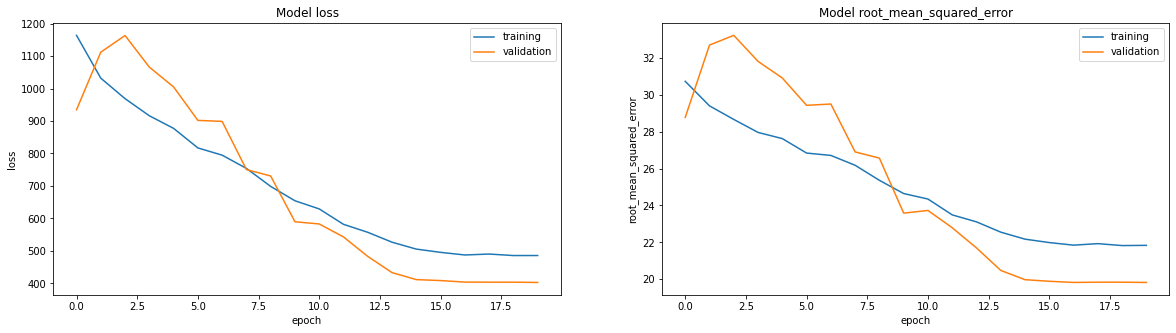

In [14]:
''' first model with only the input layer used for the tabular data'''

model_img = tf.keras.Input(shape = image_train.shape[1:])

model_img_1 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(64,64,3),padding='same')(model_img)
model_img_2 = tf.keras.layers.MaxPool2D((2,2))(model_img_1)

model_img_3 = tf.keras.layers.Dropout(0.3)(model_img_2)
model_img_4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(model_img_3)
model_img_5 = tf.keras.layers.MaxPool2D((2,2))(model_img_4)
model_img_6 = layers.BatchNormalization()(model_img_5)

model_img_7 = tf.keras.layers.Dropout(0.3)(model_img_6)
model_img_8 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(model_img_7)
model_img_9 = tf.keras.layers.MaxPool2D((2,2))(model_img_8)
model_img_10 = layers.BatchNormalization()(model_img_9)

model_img_11 = tf.keras.layers.Dropout(0.3)(model_img_10)
model_img_12 = tf.keras.layers.Conv2D(512,(3,3),activation='relu',padding='same',activity_regularizer=regularizers.l2(1e-4))(model_img_11)
model_img_13 = tf.keras.layers.MaxPool2D((2,2))(model_img_12)
model_img_14 = layers.BatchNormalization()(model_img_13)

model_img_15 = tf.keras.layers.Flatten()(model_img_14)
model_img_16 = tf.keras.layers.Dense(256, activation='relu')(model_img_15)
model_img_17 = tf.keras.layers.Dropout(0.7)(model_img_16)
model_img_18 = tf.keras.layers.Dense(128,activation='relu')(model_img_17)
model_img_19 = tf.keras.layers.Dropout(0.7)(model_img_18)
model_img_20 = tf.keras.layers.Dense(64,activation='relu',activity_regularizer=regularizers.l2(1e-1))(model_img_19)
model_img_21 = tf.keras.layers.Dropout(0.7)(model_img_20)

##### tabular
test_2_tabular = tf.keras.Input(shape = X.shape[1:], name = 'tabular') 
# test_2_tabular1 = tf.keras.layers.Dense(30, activation='relu', name='tabular1')(test_2_tabular)
# test_2_tabular2 = tf.keras.layers.Dense(50, activation='relu', name='tabular2')(test_2_tabular1)
# test_2_tabular3 = tf.keras.layers.Dense(30, activation='relu', name='tabular3')(test_2_tabular2)
# test_2_tabular4 = tf.keras.layers.Dense(10, activation='relu', name='tabular4')(test_2_tabular3)

model_concat = tf.keras.layers.Concatenate(name = 'connection', axis = 1)([test_2_tabular, model_img_21])

model_fin = tf.keras.layers.Dense(1, activation = 'linear', name = 'finished' )(model_concat)


model = tf.keras.Model(inputs = [model_img, test_2_tabular], outputs = model_fin)


preprocess = {'featurewise_center': True, 'featurewise_std_normalization': True}

# train the model and evaluate it with the test_data
train_and_evaluate_2(model, image_train, label_train, image_test, label_test, X_train, X_test, preprocess, epochs=20)

Epoch 1/20
248/248 [==============================] - 6s 19ms/step - loss: 864.7964 - root_mean_squared_error: 26.7693 - val_loss: 477.0616 - val_root_mean_squared_error: 21.3765
Epoch 2/20
248/248 [==============================] - 4s 18ms/step - loss: 491.3222 - root_mean_squared_error: 21.5294 - val_loss: 411.5627 - val_root_mean_squared_error: 20.0311
Epoch 3/20
248/248 [==============================] - 4s 18ms/step - loss: 458.9509 - root_mean_squared_error: 21.0335 - val_loss: 407.0247 - val_root_mean_squared_error: 19.8302
Epoch 4/20
248/248 [==============================] - 4s 18ms/step - loss: 451.1807 - root_mean_squared_error: 20.9565 - val_loss: 401.2947 - val_root_mean_squared_error: 19.7986
Epoch 5/20
248/248 [==============================] - 5s 18ms/step - loss: 445.0749 - root_mean_squared_error: 20.8705 - val_loss: 397.6397 - val_root_mean_squared_error: 19.7776
Epoch 6/20
248/248 [==============================] - 4s 18ms/step - loss: 442.4364 - root_mean_squared_e

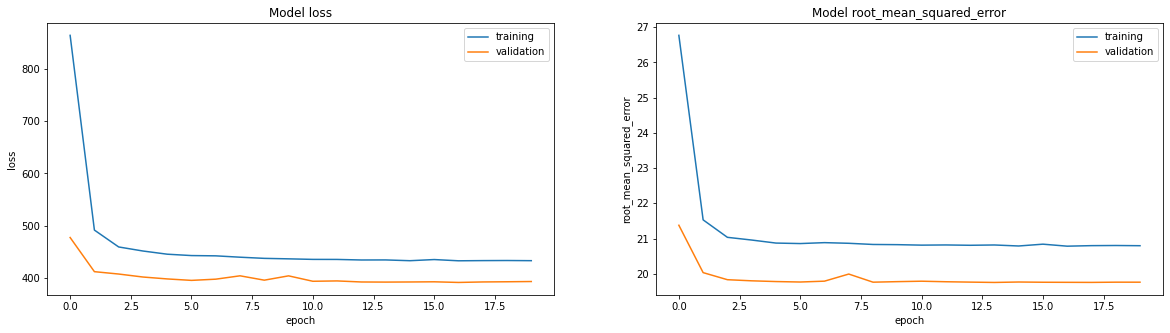

In [15]:
''' Second model where the tabular data has 4 dense layers'''

model_img = tf.keras.Input(shape = image_train.shape[1:])

model_img_1 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(64,64,3),padding='same')(model_img)
model_img_2 = tf.keras.layers.MaxPool2D((2,2))(model_img_1)

model_img_3 = tf.keras.layers.Dropout(0.3)(model_img_2)
model_img_4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(model_img_3)
model_img_5 = tf.keras.layers.MaxPool2D((2,2))(model_img_4)
model_img_6 = layers.BatchNormalization()(model_img_5)

model_img_7 = tf.keras.layers.Dropout(0.3)(model_img_6)
model_img_8 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(model_img_7)
model_img_9 = tf.keras.layers.MaxPool2D((2,2))(model_img_8)
model_img_10 = layers.BatchNormalization()(model_img_9)

model_img_11 = tf.keras.layers.Dropout(0.3)(model_img_10)
model_img_12 = tf.keras.layers.Conv2D(512,(3,3),activation='relu',padding='same',activity_regularizer=regularizers.l2(1e-4))(model_img_11)
model_img_13 = tf.keras.layers.MaxPool2D((2,2))(model_img_12)
model_img_14 = layers.BatchNormalization()(model_img_13)

model_img_15 = tf.keras.layers.Flatten()(model_img_14)
model_img_16 = tf.keras.layers.Dense(256, activation='relu')(model_img_15)
model_img_17 = tf.keras.layers.Dropout(0.7)(model_img_16)
model_img_18 = tf.keras.layers.Dense(128,activation='relu')(model_img_17)
model_img_19 = tf.keras.layers.Dropout(0.7)(model_img_18)
model_img_20 = tf.keras.layers.Dense(64,activation='relu',activity_regularizer=regularizers.l2(1e-1))(model_img_19)
model_img_21 = tf.keras.layers.Dropout(0.7)(model_img_20)

##### tabular
test_2_tabular = tf.keras.Input(shape = X.shape[1:], name = 'tabular') 
test_2_tabular1 = tf.keras.layers.Dense(30, activation='relu', name='tabular1')(test_2_tabular)
test_2_tabular2 = tf.keras.layers.Dense(50, activation='relu', name='tabular2')(test_2_tabular1)
test_2_tabular3 = tf.keras.layers.Dense(30, activation='relu', name='tabular3')(test_2_tabular2)
test_2_tabular4 = tf.keras.layers.Dense(10, activation='relu', name='tabular4')(test_2_tabular3)

model_concat = tf.keras.layers.Concatenate(name = 'connection', axis = 1)([test_2_tabular4, model_img_21])

model_fin = tf.keras.layers.Dense(1, activation = 'linear', name = 'finished' )(model_concat)


model = tf.keras.Model(inputs = [model_img, test_2_tabular], outputs = model_fin)


preprocess = {'featurewise_center': True, 'featurewise_std_normalization': True}

# train the model and evaluate it with the test_data
train_and_evaluate_2(model, image_train, label_train, image_test, label_test, X_train, X_test, preprocess, epochs=20)

Epoch 1/20
248/248 [==============================] - 6s 19ms/step - loss: 662.1674 - root_mean_squared_error: 24.1748 - val_loss: 418.4516 - val_root_mean_squared_error: 20.1177
Epoch 2/20
248/248 [==============================] - 5s 18ms/step - loss: 478.6403 - root_mean_squared_error: 21.3398 - val_loss: 413.2720 - val_root_mean_squared_error: 20.0102
Epoch 3/20
248/248 [==============================] - 5s 18ms/step - loss: 470.0695 - root_mean_squared_error: 21.3617 - val_loss: 410.2511 - val_root_mean_squared_error: 19.8811
Epoch 4/20
248/248 [==============================] - 5s 18ms/step - loss: 459.7788 - root_mean_squared_error: 21.1940 - val_loss: 401.1210 - val_root_mean_squared_error: 19.8294
Epoch 5/20
248/248 [==============================] - 5s 18ms/step - loss: 455.7619 - root_mean_squared_error: 21.1784 - val_loss: 408.2787 - val_root_mean_squared_error: 19.9200
Epoch 6/20
248/248 [==============================] - 5s 18ms/step - loss: 455.5533 - root_mean_squared_e

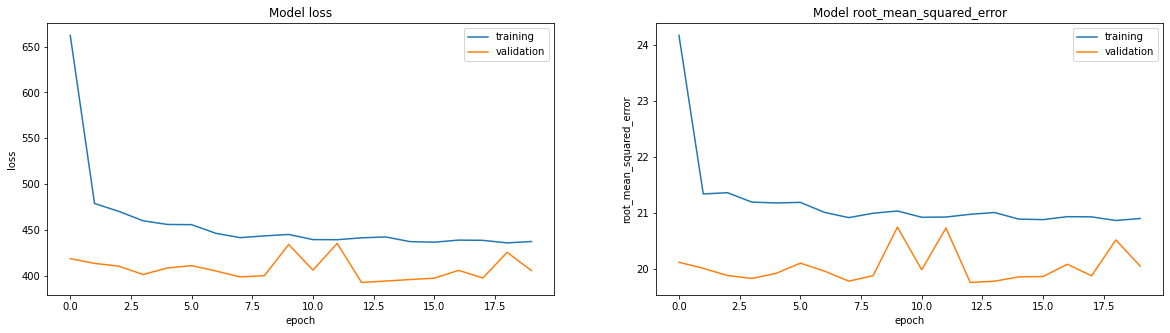

In [16]:
''' Thirth layer with 8 dense layers for the tabular data '''

model_img = tf.keras.Input(shape = image_train.shape[1:])

model_img_1 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(64,64,3),padding='same')(model_img)
model_img_2 = tf.keras.layers.MaxPool2D((2,2))(model_img_1)

model_img_3 = tf.keras.layers.Dropout(0.3)(model_img_2)
model_img_4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(model_img_3)
model_img_5 = tf.keras.layers.MaxPool2D((2,2))(model_img_4)
model_img_6 = layers.BatchNormalization()(model_img_5)

model_img_7 = tf.keras.layers.Dropout(0.3)(model_img_6)
model_img_8 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(model_img_7)
model_img_9 = tf.keras.layers.MaxPool2D((2,2))(model_img_8)
model_img_10 = layers.BatchNormalization()(model_img_9)

model_img_11 = tf.keras.layers.Dropout(0.3)(model_img_10)
model_img_12 = tf.keras.layers.Conv2D(512,(3,3),activation='relu',padding='same',activity_regularizer=regularizers.l2(1e-4))(model_img_11)
model_img_13 = tf.keras.layers.MaxPool2D((2,2))(model_img_12)
model_img_14 = layers.BatchNormalization()(model_img_13)

model_img_15 = tf.keras.layers.Flatten()(model_img_14)
model_img_16 = tf.keras.layers.Dense(256, activation='relu')(model_img_15)
model_img_17 = tf.keras.layers.Dropout(0.7)(model_img_16)
model_img_18 = tf.keras.layers.Dense(128,activation='relu')(model_img_17)
model_img_19 = tf.keras.layers.Dropout(0.7)(model_img_18)
model_img_20 = tf.keras.layers.Dense(64,activation='relu',activity_regularizer=regularizers.l2(1e-1))(model_img_19)
model_img_21 = tf.keras.layers.Dropout(0.7)(model_img_20)

##### tabular
test_2_tabular = tf.keras.Input(shape = X.shape[1:], name = 'tabular') 
test_2_tabular1 = tf.keras.layers.Dense(30, activation='relu')(test_2_tabular)
test_2_tabular2 = tf.keras.layers.Dense(90, activation='relu')(test_2_tabular1)
test_2_tabular3 = tf.keras.layers.Dense(270, activation='relu')(test_2_tabular2)
test_2_tabular4 = tf.keras.layers.Dense(810, activation='relu')(test_2_tabular3)
test_2_tabular5 = tf.keras.layers.Dense(270, activation='relu')(test_2_tabular4)
test_2_tabular6 = tf.keras.layers.Dense(90, activation='relu')(test_2_tabular5)
test_2_tabular7 = tf.keras.layers.Dense(30, activation='relu')(test_2_tabular6)
test_2_tabular8 = tf.keras.layers.Dense(12, activation='relu')(test_2_tabular7)

model_concat = tf.keras.layers.Concatenate(name = 'connection', axis = 1)([test_2_tabular8, model_img_21])

model_fin = tf.keras.layers.Dense(1, activation = 'linear', name = 'finished' )(model_concat)


model = tf.keras.Model(inputs = [model_img, test_2_tabular], outputs = model_fin)


preprocess = {'featurewise_center': True, 'featurewise_std_normalization': True}

# train the model and evaluate it with the test_data
train_and_evaluate_2(model, image_train, label_train, image_test, label_test, X_train, X_test, preprocess, epochs=20)

Epoch 1/20
248/248 [==============================] - 14s 19ms/step - loss: 1163.0647 - root_mean_squared_error: 30.7056 - val_loss: 1021.4459 - val_root_mean_squared_error: 30.4878
Epoch 2/20
248/248 [==============================] - 4s 16ms/step - loss: 1040.2194 - root_mean_squared_error: 29.3720 - val_loss: 1272.2302 - val_root_mean_squared_error: 35.1056
Epoch 3/20
248/248 [==============================] - 4s 16ms/step - loss: 993.2044 - root_mean_squared_error: 28.9692 - val_loss: 1065.0549 - val_root_mean_squared_error: 31.7314
Epoch 4/20
248/248 [==============================] - 4s 16ms/step - loss: 985.0556 - root_mean_squared_error: 29.0211 - val_loss: 1072.4600 - val_root_mean_squared_error: 31.1135
Epoch 5/20
248/248 [==============================] - 4s 16ms/step - loss: 914.6057 - root_mean_squared_error: 27.9872 - val_loss: 1156.7386 - val_root_mean_squared_error: 33.4350
Epoch 6/20
248/248 [==============================] - 4s 16ms/step - loss: 885.6205 - root_mean_s

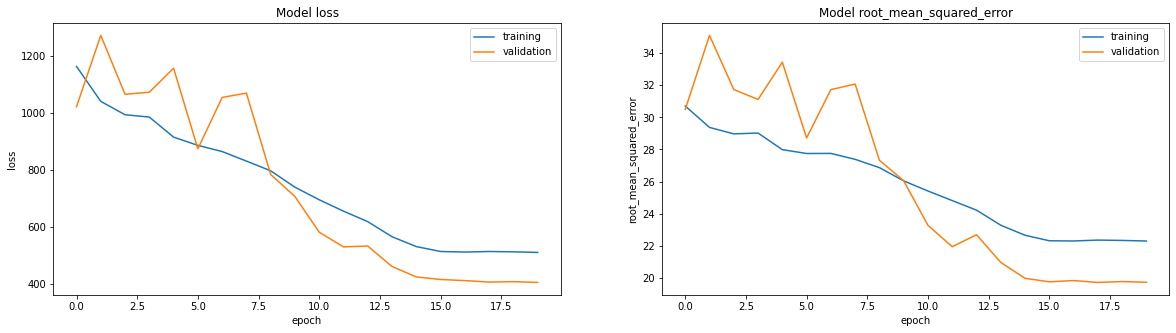

62/62 [==============================] - 0s 7ms/step - loss: 403.8979 - root_mean_squared_error: 19.7263
Validation Accuracy: 19.726261138916016


In [13]:
''' Last model which is the same model as the others but without using the 
    tabular data at all'''
    
model_img = tf.keras.Input(shape = image_train.shape[1:])

model_img_1 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(64,64,3),padding='same')(model_img)
model_img_2 = tf.keras.layers.MaxPool2D((2,2))(model_img_1)

model_img_3 = tf.keras.layers.Dropout(0.3)(model_img_2)
model_img_4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(model_img_3)
model_img_5 = tf.keras.layers.MaxPool2D((2,2))(model_img_4)
model_img_6 = layers.BatchNormalization()(model_img_5)

model_img_7 = tf.keras.layers.Dropout(0.3)(model_img_6)
model_img_8 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(model_img_7)
model_img_9 = tf.keras.layers.MaxPool2D((2,2))(model_img_8)
model_img_10 = layers.BatchNormalization()(model_img_9)

model_img_11 = tf.keras.layers.Dropout(0.3)(model_img_10)
model_img_12 = tf.keras.layers.Conv2D(512,(3,3),activation='relu',padding='same',activity_regularizer=regularizers.l2(1e-4))(model_img_11)
model_img_13 = tf.keras.layers.MaxPool2D((2,2))(model_img_12)
model_img_14 = layers.BatchNormalization()(model_img_13)

model_img_15 = tf.keras.layers.Flatten()(model_img_14)
model_img_16 = tf.keras.layers.Dense(256, activation='relu')(model_img_15)
model_img_17 = tf.keras.layers.Dropout(0.7)(model_img_16)
model_img_18 = tf.keras.layers.Dense(128,activation='relu')(model_img_17)
model_img_19 = tf.keras.layers.Dropout(0.7)(model_img_18)
model_img_20 = tf.keras.layers.Dense(64,activation='relu',activity_regularizer=regularizers.l2(1e-1))(model_img_19)
model_img_21 = tf.keras.layers.Dropout(0.7)(model_img_20)

##### tabular
# test_2_tabular = tf.keras.Input(shape = X.shape[1:], name = 'tabular') 
# test_2_tabular1 = tf.keras.layers.Dense(30, activation='relu')(test_2_tabular)
# test_2_tabular2 = tf.keras.layers.Dense(90, activation='relu')(test_2_tabular1)
# test_2_tabular3 = tf.keras.layers.Dense(270, activation='relu')(test_2_tabular2)
# test_2_tabular4 = tf.keras.layers.Dense(810, activation='relu')(test_2_tabular3)
# test_2_tabular5 = tf.keras.layers.Dense(270, activation='relu')(test_2_tabular4)
# test_2_tabular6 = tf.keras.layers.Dense(90, activation='relu')(test_2_tabular5)
# test_2_tabular7 = tf.keras.layers.Dense(30, activation='relu')(test_2_tabular6)
# test_2_tabular8 = tf.keras.layers.Dense(12, activation='relu')(test_2_tabular7)

# model_concat = tf.keras.layers.Concatenate(name = 'connection', axis = 1)([test_2_tabular8, model_img_21])

model_fin = tf.keras.layers.Dense(1, activation = 'linear', name = 'finished' )(model_img_21)


model = tf.keras.Model(inputs = [model_img], outputs = model_fin)


preprocess = {'featurewise_center': True, 'featurewise_std_normalization': True}

# train the model and evaluate it with the test_data
train_and_evaluate(model, image_train, label_train, image_test, label_test, preprocess, epochs=20)

# Test codes
different codes to test the model, first is the 8 test images from the kaggle petfinder competition. Second code is a test by getting 8 images from the traindata to compare what this model will give for score to what the tabular data has as pawpularity score.

In [10]:
''' to test the model on the test images from kaggle'''

test_images = []

test_names = []
for filename in os.listdir('test'):
    name = filename.strip('.jpg')
    test_names.append(name)
    img = cv2.imread(os.path.join('test',filename))
    if img is not None:
        test_images.append(img)

In [11]:

test_images = np.array(test_images)
model.predict(test_images)


ValueError: ignored

In [ ]:
''' Test by using 8 images from the train data'''
print(model.predict(image[0:8]))

print(label_train[0:8])